# Eye-tracker pupil detection model   
<hr></hr>
<b>Author:</b> Owen Burt  

<b>Date created:</b> 2/21/2025

<b>Last modified</b> 4/26/2025  

<hr></hr>

<b>Description:</b>  

In this notebook I prepare data and construct a model that predicts the location of a pupil. 

<b>References:</b>  
- Referenced <b>mathworks.com</b> to learn about r-cnn, fast r-cnn, and faster r-cnn.
- Referenced and used code from the AI text book 'Applied Machine Learning and AI for Engineers' used in the AI/ML course by <b>Jeff Prosise</b>.
- Referenced and used code from <b>Tensorflow</b> to help understand tensorflows framework, use their pre-trained models, and output images with matlibplot.
- Referneced paper on Faster Convolutional Neural Networks from Cornell Univeristy called 'Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks' by <b>Shaoqing Ren, et al</b>. I used this article to help me understand the Faster R-CNN.

<b>Sources:</b>  
- mathworks.com: https://www.mathworks.com/help/vision/ug/getting-started-with-r-cnn-fast-r-cnn-and-faster-r-cnn.html
- Tensorflow: https://www.tensorflow.org/tutorials/images/cnn
- Cornell Univeristy: https://arxiv.org/abs/1506.01497  


<hr></hr>
  


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import os as os
import cv2


## Data preprocessing

I'm starting with a folder containing all the images and their corresponding annotations as well as a csv that contains the file name of the image and the boundries of the pupil. In order to train a model on this data I will need each image (features) to be a 3D array conatinaing pixel data and the boundries (target) to be an array that corresponds to the correct image in the 3D array of images.


In [ ]:
cwd = os.getcwd()
df = pd.read_csv(cwd + "/eye_data.csv")


In [57]:
df.head()

,file_name,obj_class,x1,y1,x2,y2
0,WIN_20250205_16_00_55_Pro.jpg,pupil,257,163,276,195
1,WIN_20250205_16_00_56_Pro.jpg,pupil,279,128,308,156
2,WIN_20250205_16_00_57_Pro.jpg,pupil,313,138,346,170
3,WIN_20250205_16_00_58_Pro.jpg,pupil,278,141,305,172
4,WIN_20250205_16_00_59_Pro.jpg,pupil,263,150,286,181


In [ ]:
def view_image(image, x1, y1, x2, y2):
    ''' 
    view_image displays the bounding box on the image.

    :param image: a numpy array representing the image.
    :param x1: x min coordinates.
    :param y1: y min coordinates.
    :param x2: x max coordinates.
    :param y2: y max coordinates.
    '''

    image = image.copy()
    color = (0, 255, 0)
    thickness = 2

    cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
    cv2.imshow('Bounding Box', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

In [ ]:
img_path = cwd + '\\image_data\\' + df['file_name'][0]
img = cv2.imread(img_path)
x1 = df['x1'][0]
y1 = df['y1'][0]
x2 = df['x2'][0]
y2 = df['y2'][0]
view_image(img, x1, y1, x2, y2)


### Splitting data into training, testing, and validation groups.


My training data will be 75% of original dataset, testing will be 10%, and validation will be 15%


In [ ]:

from sklearn.model_selection import train_test_split

X = df['file_name']
y = df[['x1', 'y1', 'x2', 'y2']]

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1 - train_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_ratio/(test_ratio + validation_ratio)) 



Resetting indices

In [ ]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)


In [ ]:
img_path = cwd + '\\image_data\\' + X_train[1]
img= cv2.imread(img_path)
x1 = y_train['x1'][1]
y1 = y_train['y1'][1]
x2 = y_train['x2'][1]
y2 = y_train['y2'][1]
view_image(img, x1, y1, x2, y2)


In [63]:
X_val.head()

0    WIN_20250220_19_59_05_Pro.jpg
1    WIN_20250208_18_41_52_Pro.jpg
2    WIN_20250208_18_44_29_Pro.jpg
3    WIN_20250220_20_00_40_Pro.jpg
4    WIN_20250208_18_45_34_Pro.jpg
Name: file_name, dtype: object

In [64]:
y_val.head()

,x1,y1,x2,y2
0,0,0,0,0
1,277,152,307,186
2,332,146,355,167
3,0,0,0,0
4,308,164,327,186


### Converting images and boundry data to arrays and normalizing 

Currently, <b>X_data</b> is a <u>series</u> of file names and <b>y_data</b> is a <u>dataframe</u> containing boundry data. I want the training data to be an <u>array</u> of pixel data and the target data to be an <u>array</u> containing just the boundries with no labels/index. I will create a function that handles both of these tasks. Along with converting data to array format these funcitons will also handle normalizing the data. For the images I do this by dividing the pixel data by 255 since a pixel is comprised of three values ranging from 0 to 255. Dividing by 255 gives me pixel data that ranges from 0 to 1. I treat the boudries similarly and divide x values by the width of my image and y values by the height leaving me with boundry data that ranges form 0 to 1. 


In [65]:
X_test.head()

0    WIN_20250205_16_22_00_Pro.jpg
1    WIN_20250208_18_40_34_Pro.jpg
2    WIN_20250208_18_43_45_Pro.jpg
3    WIN_20250208_18_41_08_Pro.jpg
4    WIN_20250205_16_22_15_Pro.jpg
Name: file_name, dtype: object

In [66]:
type(X_test[1])

str

#### Creating functions

In [67]:
from PIL import Image

def images_to_arr(X):
    '''
    images_to_arr gets image path, loads the image, then converts it to a 3D array. 
    
    :param X: the series of image file names to be converted.
    '''
    X_data = []
    for i in range(len(X)):
        img_path = cwd + '\\image_data\\' + X[i]
        img = cv2.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_512x512 = cv2.resize(gray_img, (512, 512))       
        
        X_data.append(img_512x512)
    return X_data


In [ ]:
def bounds_to_arr(y_data):
    '''
    bounds_to_arr converts boundry data from a dataframe to a np array containing just the coordinates. 
        It also normalizes the boundry values to be between 0 and 1

    :param y: the dataframe of boundry data to be converted.
    '''
    final = []
    for i in range(len(y_data)):
        df = y_data.loc[i]
        x1new = round((df['x1']/640), 2)
        y1new = round((df['y1']/360), 2)
        x2new = round((df['x2']/640), 2)
        y2new = round((df['y2']/360), 2)
        final.append((x1new, y1new, x2new, y2new))
    return np.array(final)


#### Executing functions

In [ ]:
X_train = images_to_arr(X_train)
y_train = bounds_to_arr(y_train)
X_test = images_to_arr(X_test)
y_test = bounds_to_arr(y_test)
X_val = images_to_arr(X_val)
y_val = bounds_to_arr(y_val)


#### Visualizing data after preprocessing is complete

In [ ]:
x1 = int(y_train[56][0]*512)
y1 = int(y_train[56][1]*512)
x2 = int(y_train[56][2]*512)
y2 = int(y_train[56][3]*512)
view_image((X_train[56]), x1, y1, x2, y2)


<hr></hr>

### Cropping the image to get just the eyeball

In [ ]:
def crop_image(X_data):
    ''' 
    crop_image removes 1/3 from all sides of the image.

    :param X_data: image data as an array.
    '''
    array = []
    for i in range(len(X_data)):
        img = X_data[i]
        img_small = img[171: 341, 171: 341]
        img_norm = np.round(img_small/255, 2)
        array.append(img_norm)
    return np.array(array)


In [ ]:
def crop_bounds(y_data):
    final = []
    for i in range(len(y_data)):
        arr = y_data[i]
        x1new = arr[0]-0.333333
        y1new = arr[1]-0.333333
        x2new = arr[2]-0.333333
        y2new = arr[3]-0.333333
        final.append((x1new, y1new, x2new, y2new))
    return np.array(final)


### Calling functions

In [ ]:
X_train = crop_image(X_train)
X_test = crop_image(X_test)
X_val = crop_image(X_val)
y_train = crop_bounds(y_train)
y_test = crop_bounds(y_test)
y_val = crop_bounds(y_val)


In [ ]:
x1 = int(y_train[4][0]*512)
y1 = int(y_train[4][1]*512)
x2 = int(y_train[4][2]*512)
y2 = int(y_train[4][3]*512)
view_image(X_train[4], x1, y1, x2, y2)


## Selecting and Building a Model  

I am beginning by pretty much copying a model from the 'Applied Machine Learning and AI for Engineers' text book to get a benchmark of where the data is at and what my model might need. The originial code can be found in the text book on page 254. I made one edit to the code and changed the loss funciton to mean squared error since my output layer is of size 4.  

### Running a Simple Convolutional Neural Network for Experimentation  

- the type of model is important and I should read more about this.  
- Conv2D applies a convolution (2-dimentional for images since images are 2D) to the input image. 
The parameter 64 refers to the number of filters applied in the covolution.
a filter is a stack of kernels. In this case each filter has 3 kernels since there are three channels specified in the input_shape param (image are usually RGB hence 3 channels. one for red one for green one for blue)
The second param (3, 3) specifies the shape of the kerel applied.
I should really learn more about activation functions relu or rectified linear unifying is common but this should be selected based on your data
imput shape refers to the size of the image being passed into the layer. In this case I resized all of my images to be 512 pixels wide and 512 pixels high. Each image is not RGB so maybe I should change the channel.
- Pooling is done to decrease compute time and helps to control overfitting by reducing the feature map output by the previous layer. 
Here were using maxpooling2d with shape 2x2 I am pretty sure this slides a 2x2 matrix across the featuremap reducing that 2x2 portion of the 
image down to a 1x1 block containing the maximum value in the 2x2 matrix.
- Fully connected layers require 1D imputs. A flattening layer is added to convert 2D or 3D tensor (tensor is can be thought of as a n-dimentional matrix in this case 2x2 matrix) into a 1D vector
- The dense layers convert the flattened feature maps to probabilities. the first param is how many output units youwant
In this case my final dense layer has 4 units since I am predicting 4 points for boundries. 
activation matters and I should look more into this.

In [ ]:
#one edit I made was to change the loss funciton to mean squared error.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

loss = Huber(delta=1.0)

model = Sequential()
model.add(Conv2D(24, (3, 3), activation='relu', input_shape=(170, 170, 1)))
model.add(MaxPooling2D(2, 2)) 
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(2, 2)) 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='linear'))
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss=loss,
             metrics=['accuracy'])
model.summary(line_length=80)


Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_4 (Conv2D)                  (None, 168, 168, 24)            240         
                                                                                
 max_pooling2d_4 (MaxPooling2D)     (None, 84, 84, 24)              0           
                                                                                
 conv2d_5 (Conv2D)                  (None, 82, 82, 32)              6944        
                                                                                
 max_pooling2d_5 (MaxPooling2D)     (None, 41, 41, 32)              0           
                                                                                
 conv2d_6 (Conv2D)                  (None, 39, 39, 64)              18496       
                                                                                
 max_p

In [77]:
def view_accuracy_metrics(hist):
    ''' 
    view_accuracy_metrics displays a graph showing training and validation accuracy.

    :param hist: object containing info about training process.
    '''
    sns.set()
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()

In [78]:
hist = model.fit(X_train, y_train,
                validation_data=(X_val, y_val),
                batch_size=30, epochs=15)

Epoch 1/15
10/10 [==============================] - 2s 213ms/step - loss: 0.0167 - accuracy: 0.4964 - val_loss: 0.0097 - val_accuracy: 0.3636
Epoch 2/15
10/10 [==============================] - 2s 189ms/step - loss: 0.0151 - accuracy: 0.3587 - val_loss: 0.0094 - val_accuracy: 0.5273
Epoch 3/15
10/10 [==============================] - 4s 385ms/step - loss: 0.0148 - accuracy: 0.3478 - val_loss: 0.0095 - val_accuracy: 0.3636
Epoch 4/15
10/10 [==============================] - 4s 427ms/step - loss: 0.0145 - accuracy: 0.4891 - val_loss: 0.0095 - val_accuracy: 0.3818
Epoch 5/15
10/10 [==============================] - 4s 410ms/step - loss: 0.0143 - accuracy: 0.4783 - val_loss: 0.0091 - val_accuracy: 0.4000
Epoch 6/15
10/10 [==============================] - 4s 372ms/step - loss: 0.0141 - accuracy: 0.4710 - val_loss: 0.0090 - val_accuracy: 0.4545
Epoch 7/15
10/10 [==============================] - 3s 326ms/step - loss: 0.0140 - accuracy: 0.5109 - val_loss: 0.0091 - val_accuracy: 0.4545
Epoch 

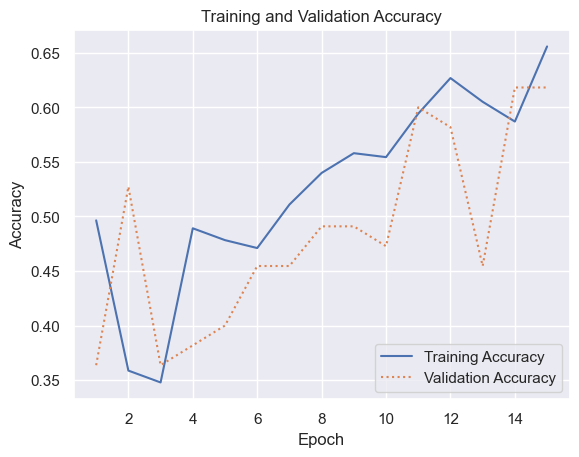

In [79]:
view_accuracy_metrics(hist)

In [80]:
bounds = model.predict(X_test)

2/2 [==============================] - 0s 14ms/step


In [129]:
bounds

array([[ 0.045476  ,  0.08257373,  0.07179084,  0.14331627],
       [ 0.15082982,  0.1322296 ,  0.1782518 ,  0.19003028],
       [ 0.12890488,  0.07855161,  0.14366212,  0.18055636],
       [-0.07760832, -0.02170655, -0.07280105,  0.02678266],
       [ 0.07053925,  0.08739633,  0.11859187,  0.1701971 ],
       [ 0.17280188,  0.15384409,  0.19745244,  0.20107563],
       [ 0.14098775,  0.05782094,  0.20221542,  0.15753001],
       [ 0.20381138,  0.12634596,  0.25052893,  0.18898672],
       [-0.01373095,  0.04733337,  0.0228324 ,  0.10840412],
       [ 0.17818652,  0.05438013,  0.23438083,  0.16157255],
       [ 0.05770892,  0.10933042,  0.0954676 ,  0.19423564],
       [ 0.05716028,  0.08819225,  0.07714114,  0.16695452],
       [ 0.13344997,  0.00601923,  0.19534351,  0.10753027],
       [ 0.17572373,  0.10419023,  0.21798451,  0.17827952],
       [ 0.13901255,  0.13727438,  0.18287383,  0.23165676],
       [ 0.06997666, -0.0291951 ,  0.09539597,  0.0317311 ],
       [-0.16281758, -0.

In [81]:
view_image(X_test[3], int(bounds[3][0]*512),
            int(bounds[3][1]*512), int(bounds[3][2]*512), int(bounds[3][3]*512))

#### Copying VGG16 model

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [66]:
def show_feat_map(model, data):
    ''' 
    show_feat_map displays the feature map (image) after each filter is applied. 

    :param result: takes in the 4D tensor output from MaxPooling2D layer with format (batch_size, rows, cols, channels). 
    '''

    model.build()
    model.summary()
    result = model.predict(data)
    for i in range(64):
        feature_img = result[0, :, :, i]
        ax = plt.subplot(8, 8, i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_img, cmap='grey')
    plt.show


In [77]:
model = Sequential()

In [78]:
#Block 1
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(170, 170, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 

In [79]:
#show_feat_map(model, X_test)

In [80]:
#Block 2
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [81]:

#Block 3
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [82]:
#show_feat_map(model, X_test)

In [83]:
#Block 4
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [84]:
#Block 5
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [85]:
#show_feat_map(model, X_test)

In [86]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='linear'))

In [87]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 170, 170, 64)      640       
                                                                 
 conv2d_21 (Conv2D)          (None, 170, 170, 64)      36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 85, 85, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 85, 85, 128)       73856     
                                                                 
 conv2d_23 (Conv2D)          (None, 85, 85, 128)       147584    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 42, 42, 128)      0         
 g2D)                                                 

In [88]:
hist = model.fit(X_train, y_train,
                validation_data=(X_test, y_test),
                batch_size=10, epochs=12)

Epoch 1/12
28/28 [==============================] - 84s 3s/step - loss: 0.0415 - mae: 0.1487 - val_loss: 0.0224 - val_mae: 0.1292
Epoch 2/12
28/28 [==============================] - 76s 3s/step - loss: 0.0298 - mae: 0.1293 - val_loss: 0.0193 - val_mae: 0.1078
Epoch 3/12
28/28 [==============================] - 77s 3s/step - loss: 0.0289 - mae: 0.1259 - val_loss: 0.0190 - val_mae: 0.1043
Epoch 4/12
28/28 [==============================] - 75s 3s/step - loss: 0.0287 - mae: 0.1208 - val_loss: 0.0187 - val_mae: 0.1010
Epoch 5/12
28/28 [==============================] - 74s 3s/step - loss: 0.0288 - mae: 0.1153 - val_loss: 0.0186 - val_mae: 0.1001
Epoch 6/12
28/28 [==============================] - 74s 3s/step - loss: 0.0289 - mae: 0.1270 - val_loss: 0.0199 - val_mae: 0.1127
Epoch 7/12
28/28 [==============================] - 74s 3s/step - loss: 0.0287 - mae: 0.1189 - val_loss: 0.0181 - val_mae: 0.0946
Epoch 8/12
28/28 [==============================] - 77s 3s/step - loss: 0.0287 - mae: 0.11

In [90]:
view_accuracy_metrics(hist)

KeyError: 'accuracy'

In [91]:
bounds = model.predict(X_test)
view_image(X_test[0], int(bounds[1][0]*512),
            int(bounds[1][1]*512), int(bounds[1][2]*512), int(bounds[1][3]*512))

2/2 [==============================] - 1s 200ms/step
